# QuantBot Challenge - Zachary Tiller

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Functions

In [170]:
def check_for_unique_IDs(price, static):
    """Checks that the IDs in price and static dataframes are consistent"""
    
    for ID in np.unique(np.array(prices['internal_id'])):
        if ID not in np.array(static.index):
            print('Unrecognised ID found: {}'.format(ID))
    else:
        print('All IDS match')
    return None


def fill_endpoints(dfs):
    """Backward fills any NaNs in the first row of the dataframe, forward fills any at end"""
    for df in dfs:
        df.bfill(inplace=True)
        df.ffill(inplace=True)

        
def convert_to_USD(dfs):
    """Converts the closing prices and market cap. into USD and adds these rows to the dataframe"""
    for df in dfs:
        df['close USD'] = df['close']*df['fx_to_usd']
        df['mkt_cap_USD'] = df['mkt_cap']*df['fx_to_usd']
        
        
def compute_n_day_MA(n, dfs):
    """Computes the Moving Average of Closing Prices for a window of n"""
    for df in dfs:
        df['n-day MA Closing Price'] = df['close USD'].rolling(n).mean()
        
        
def compute_n_day_STDEV(n, dfs):
    """Computes the Standard Deviation of Closing Prices for a window of n"""
    for df in dfs:
        df['n-day Close STDEV'] = df['close USD'].rolling(n).std()
 

def add_historical_volatility(dfs, period):
    """
    This function adds the standard deviation of log returns as a column to the prices dataframe over a period
        Args:
            df (DataFrame) : A Dataframe which contains the time series data
            period (int) : The number of candles which we are calculating the standard deviation of log returns over.
    """
    for df in dfs:
        close = df.loc[:,"close"]
        log_returns = np.log(close/close.shift(1))
        df.loc[:,'n-day Vol MA'] = log_returns.rolling(period).std()

        
def plot_bol_bands(n, dfs):
    """This function plots the bollinger bands for each ticker"""
    fig, axs = plt.subplots(4,2, num=5, figsize=(72,72))

    titles=[[np.unique(df['internal_id'])[0] for df in dfs[:2]],
           [np.unique(df['internal_id'])[0] for df in dfs[2:4]],
            [np.unique(df['internal_id'])[0] for df in dfs[4:6]],
            [np.unique(df['internal_id'])[0] for df in dfs[6:]]]
    arr = [[0,1],
           [2,3],
           [4,5],
           [6,7]]
            
    for j, k in enumerate(axs):
        for column, ax in enumerate(k):
            idx = arr[j][column]
            df = dfs[idx]
            ax.plot(df.index, df['close USD'], label='Close Prices')
            ax.plot(df.index, df['n-day MA Closing Price'], label = 'n-Day Close MA')
            ax.plot(df.index, df['n-day MA Closing Price'] + df['n-day Close STDEV']*1.5, label = '1.5 STD n-day Upper Band')
            ax.plot(df.index, df['n-day MA Closing Price'] - df['n-day Close STDEV']*1.5, label = '1.5 STD n-day Lower Band')
            ax.legend(prop={'size':30})
            ax.set_title(titles[j][column], fontsize=60)
            ax.tick_params(axis='both', which='major', labelsize=35)

    fig.text(0.5,0.05, 'Date', ha='center', va='center', fontsize='72')    
    fig.text(0.05, 0.5, 'Close Price USD', ha='center', va='center', fontsize='72', rotation='vertical')
    fig.text(0.5,0.93, 'Bollinger Bands', ha='center', va='center', fontsize='72')  


def currency_volume_MA(n, dfs, currency_dict):
    """Function which calculates the Volume of each currency traded in USD for our given stocks
    
    Args:
        n: period
        dfs: set of dataframes to calculate volume MA for
        currency_dict: a dictionary previously made storing {TICKER: RAW CURRENCY}
           
    Returns:
        volume_df: dataframe with index as Date, columns as currency, data as raw Volume
        vol_non_rolling: dataframe with index as Date, columns as currency, data as Moving Average of Volume
    
    """
    vol_curr_dict = {k:{} for k in list(currency_dict.values())} # Currency symbol is the key. Value is the vol
    for df in dfs:
        for idx, row in df.iterrows():
            date = idx
            currency = row['Raw Currency']
            
            if date not in list(vol_curr_dict[currency].keys()):
                vol_curr_dict[currency][date] = row['tradable_volume']*row['close USD']
            else:
                vol_curr_dict[currency][date] += row['tradable_volume']*row['close USD']

    volume_df = pd.DataFrame(vol_curr_dict)
    vol_non_rolling = volume_df.copy()
    volume_df=volume_df.rolling(n).mean()
    
    return volume_df, vol_non_rolling
    
    
def plot_vol_MA(n, dfs, currency_dict):
    """Funtion to plot the Moving Average and raw value of the volume Traded for each currency in USD"""
    voldf, vol_non_rolling = currency_volume_MA(n, dfs, currency_dict)
    
    fig, axs = plt.subplots(3,2, num=5, figsize=(72,72))

    titles = [ [list(voldf.columns)[0], list(voldf.columns)[1]],
               [list(voldf.columns)[2], list(voldf.columns)[3]],
               [list(voldf.columns)[4], 'Empty'] ]
   
    arr = [[0,1],
           [2,3],
           [4,5]]
            
    for j, k in enumerate(axs):
        for column, ax in enumerate(k):
            currency = titles[j][column]
            if currency=='Empty':
                ax.plot(0,0)
            else:
                date_roll = voldf[currency].dropna().sort_index().index
                date_non_roll = vol_non_rolling[currency].dropna().sort_index().index
                
                volume_roll = voldf[currency].dropna().sort_index()
                volume_non_roll = vol_non_rolling[currency].dropna().sort_index()
                
                ax.plot(date_roll, volume_roll, label='n-Day Rolling MA')
                ax.plot(date_non_roll, volume_non_roll, label='Raw Volume')
                ax.set_title(currency, fontsize=60)
                ax.legend(prop={'size':30})
                
            ax.set_title(titles[j][column], fontsize=60)
            ax.tick_params(axis='both', which='major', labelsize=35)
            ax.yaxis.offsetText.set_fontsize(35)

    fig.text(0.5,0.05, 'Date', ha='center', va='center', fontsize='72')    
    fig.text(0.05, 0.5, 'Volume (USD)', ha='center', va='center', fontsize='72', rotation='vertical')
    fig.text(0.5,0.93, 'n-Day Volume Moving Avg Per Currency, in USD', ha='center', va='center', fontsize='72')     


### Load In The Data

In [139]:
prices = pd.read_csv("prices.csv",index_col=0)
static_data = pd.read_csv("static_data.csv",index_col=0)



### Clean-Up Data, Perform Checks & Add Useful Columns

In [140]:
# create columns for prices data
prices[['close USD', 'mkt_cap_USD']] = 999.99
prices[['n-day Vol MA', 'n-day MA Closing Price', 'n-day Close STDEV']] = 999.99 

# convert prices date to a date_time object 
prices.index = pd.to_datetime([pd.Timestamp(year=int(str(dt)[:4]), month=int(str(dt)[4:6]), day=int(str(dt)[6:])) for dt in prices.index])
prices.index.name = 'Date'

# check how many zeros there are in the data
num_zeros = np.sum(prices.isin([0]).sum(axis=1))

# replace zeros with NaNs so that later we can interpolate
prices.replace({0:float('NaN')}, inplace=True)

# we have two occurances of ADE; re-name in terms of their raw currency
static_data.loc[(static_data['symbol']=='ADE') & (static_data['currency']=='EUR'), 'symbol'] = 'ADE_EUR'
static_data.loc[(static_data['symbol']=='ADE') & (static_data['currency']=='NOK'), 'symbol'] = 'ADE_NOK'

In [141]:
# Check that the IDs of the prices are matching with IDs of static_data:
check_for_unique_IDs(prices, static_data)


All IDS match


I decided to create a dictionary of {id : symbol}, in order to replace ID with Ticker Symbol for easier dataframe reading. Also, I made a dictionary of {ticker symbol: curerency} in order to map each symbol to their raw currency

This will allow me to:

    - Seperate the prices dataframe into one for each ticker
    
    - Further allows me to investigate the data of each ticker more closely


In [142]:
# creating the symbol_dictionary
symbol_dict = {idx:row['symbol'] for idx, row in static_data.iterrows()}

# creating a currency dictionary, recording the currency each symbols data is in
currency_dict = {row['symbol']:row['currency'] for idx, row in static_data.iterrows()}

# replacing internal_id with Ticker Symbol 
prices['internal_id'] = prices['internal_id'].replace(symbol_dict)

# adding a Raw Currency row to indicate which currency each ticker data is in
prices['Raw Currency'] = prices['internal_id'].replace(currency_dict)

# fx_to_USD for GBp is out by a factor of 100; correct this
prices.loc[prices['Raw Currency']=='GBp','fx_to_usd']*=100



#### Seperate the Prices data into individual dataframes for each ticker and interpolate NaNs

In [143]:
# Define 8 dfs of the prices, and interpolate where we have NaNs
df_BALDB = prices[prices['internal_id']=='BALDB'].interpolate(method='linear')
df_WDP = prices[prices['internal_id']=='WDP'].interpolate(method='linear')
df_DEMANT = prices[prices['internal_id']=='DEMANT'].interpolate(method='linear')
df_OCDO = prices[prices['internal_id']=='OCDO'].interpolate(method='linear')
df_TWR = prices[prices['internal_id']=='TWR'].interpolate(method='linear')
df_TKO = prices[prices['internal_id']=='TKO'].interpolate(method='linear')
df_ADE_EUR = prices[prices['internal_id']=='ADE_EUR'].interpolate(method='linear')
df_ADE_NOK = prices[prices['internal_id']=='ADE_NOK'].interpolate(method='linear')

# store each dataframe in a collection (list) of dataframes
df_set = [df_ADE_EUR, df_ADE_NOK, df_BALDB, df_WDP, df_DEMANT, df_OCDO, df_TKO, df_TWR]


In [144]:
# we want to deal with any NaNs which fall at the end or start, as these arent interpolated by the interpolate method
fill_endpoints(df_set)


In [145]:
# convert monetary values to USD and add necessary rows to the datafrme
convert_to_USD(df_set)


### Data Has Been Cleaned, Perform Calculations Now

In [146]:
compute_n_day_MA(20, df_set)
compute_n_day_STDEV(20, df_set)
  

##### Re-Compute Volat21 via use of add_historical_volatility

In [148]:
add_historical_volatility(df_set, 21)

##### Compare my 21-volatility with volat_21

In [149]:
def vol_comparison(dfs):
    vol_comparison = pd.DataFrame()
    for df in dfs:
        ticker = np.unique(df['internal_id'])[0]
        vol_comparison[['volat_21 {}'.format(ticker), '{} Estimated Vol'.format(ticker)]] = df[['volat_21', 'n-day Vol MA']]
    return vol_comparison

vol_comparison = vol_comparison(df_set)

In [150]:
vol_comparison

,volat_21 ADE_EUR,ADE_EUR Estimated Vol,volat_21 ADE_NOK,ADE_NOK Estimated Vol,volat_21 BALDB,BALDB Estimated Vol,volat_21 WDP,WDP Estimated Vol,volat_21 DEMANT,DEMANT Estimated Vol,volat_21 OCDO,OCDO Estimated Vol,volat_21 TKO,TKO Estimated Vol,volat_21 TWR,TWR Estimated Vol
Date,,,,,,,,,,,,,,,,
2020-01-02,0.020289,NaN,0.016257,NaN,0.011306,NaN,0.006890,NaN,0.011913,NaN,0.014953,NaN,0.031998,NaN,0.013682,NaN
2020-01-03,0.020717,NaN,0.013143,NaN,0.011294,NaN,0.006927,NaN,0.012082,NaN,NaN,NaN,0.031998,NaN,0.013936,NaN
2020-01-06,0.021098,NaN,0.013474,NaN,0.011294,NaN,0.006338,NaN,0.011569,NaN,0.011999,NaN,0.034403,NaN,0.011667,NaN
2020-01-07,0.023551,NaN,0.015451,NaN,0.010963,NaN,0.006801,NaN,0.011673,NaN,0.014790,NaN,0.034403,NaN,0.013132,NaN
2020-01-08,0.025732,NaN,0.016627,NaN,0.011009,NaN,0.006765,NaN,0.011660,NaN,0.014751,NaN,0.034403,NaN,0.013164,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.040400,0.039384,0.026557,0.025904,0.013412,0.013090,0.015588,0.015200,0.024187,0.023584,0.025303,0.024685,0.027173,0.026485,0.033590,0.032743
2021-12-28,0.041063,0.040053,0.026571,0.025922,0.013614,0.013280,0.015132,0.014767,0.024161,0.023560,0.025303,0.024652,0.027173,0.026087,0.033618,0.032777
2021-12-29,0.037503,0.036622,0.027022,0.026367,0.013446,0.013113,0.015140,0.014775,0.024118,0.023520,0.025293,0.024399,0.026788,0.026045,0.029284,0.028544


I have noticed that my volatility estimates are a bit different from those in the volat_21 column, however, they are reasonably similar. There may be this discrepancy because I am not sure how the given volatility has been calculated; volatility can be calculated by findign the standard deviation over a range of data, the method I used, but this is a biased estimate. So, this can be corrected by introducing a correction factor, which may be a reason why the volatility is different.

Also, my volatility series begins with some Null values. The reason for this is because the method I used to calculate the volatility involved shifting the dataframe by 1 to calculate the returns, which introduces a null value, and then some more null values appear due to calculation of the window. This is not the case for the volatility column provided

## Plot The Bollinger Bands

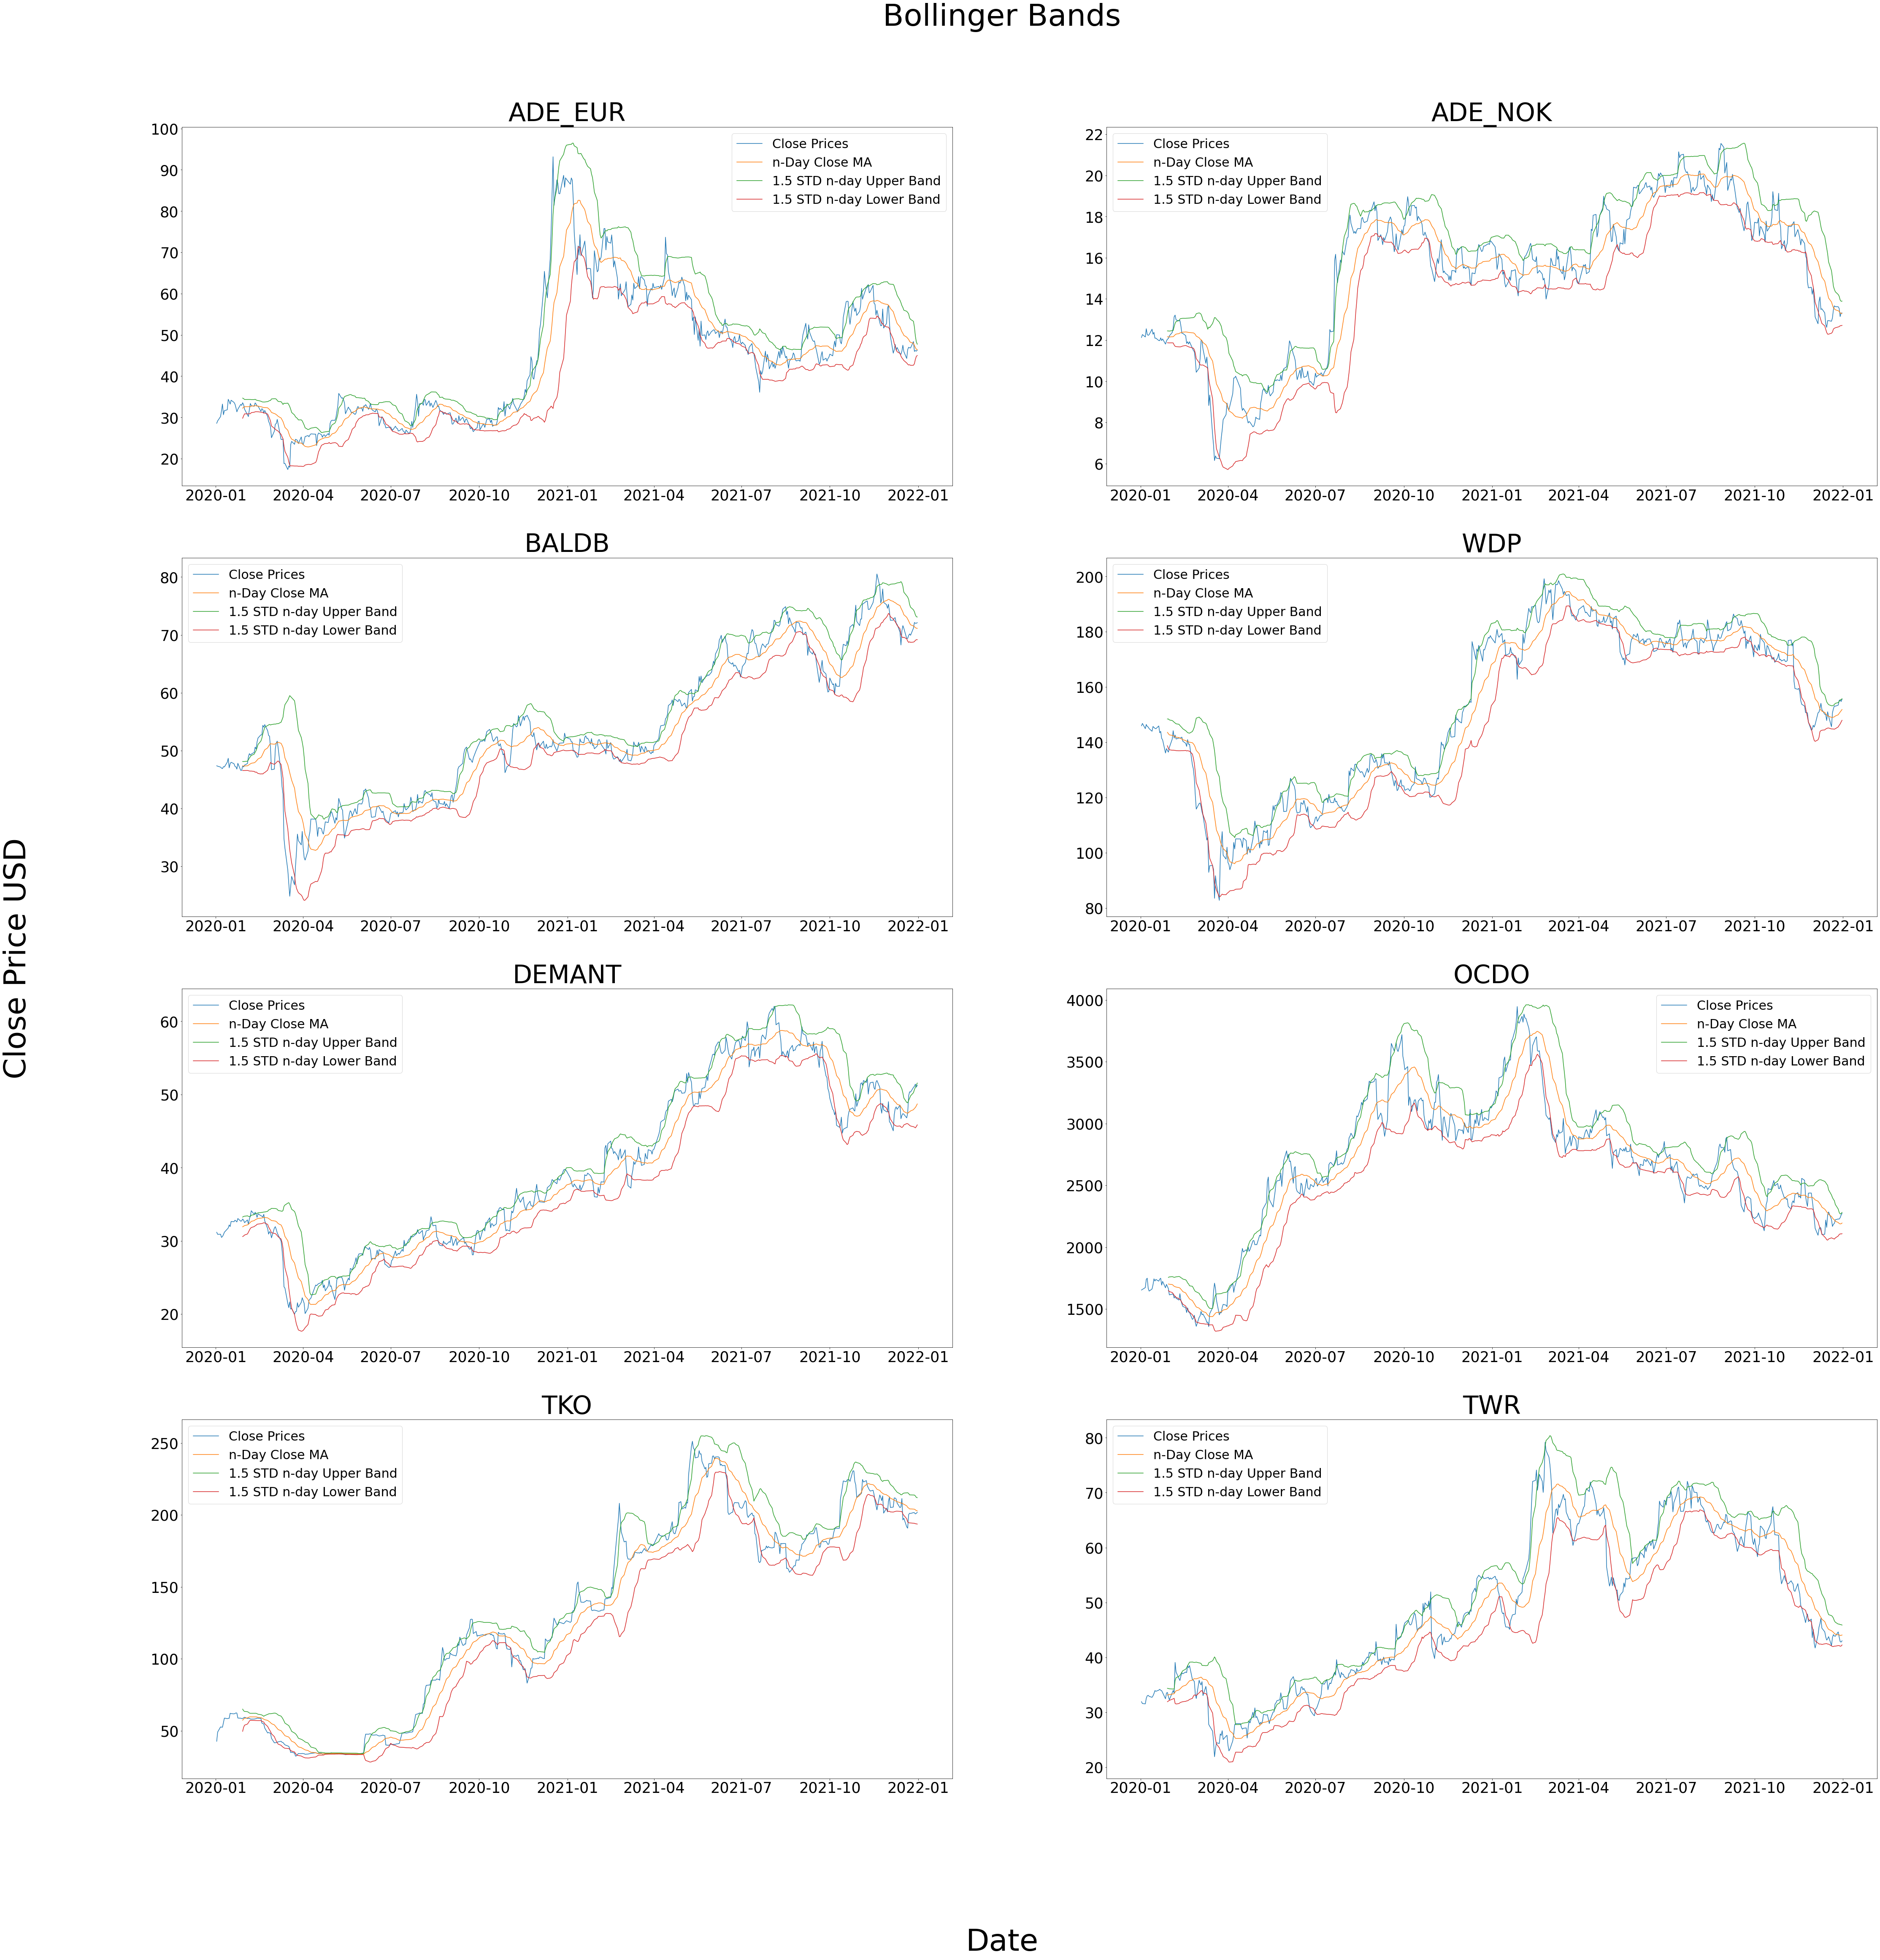

In [106]:
plot_bol_bands(20, df_set)

## Plot the Volume Moving Averages

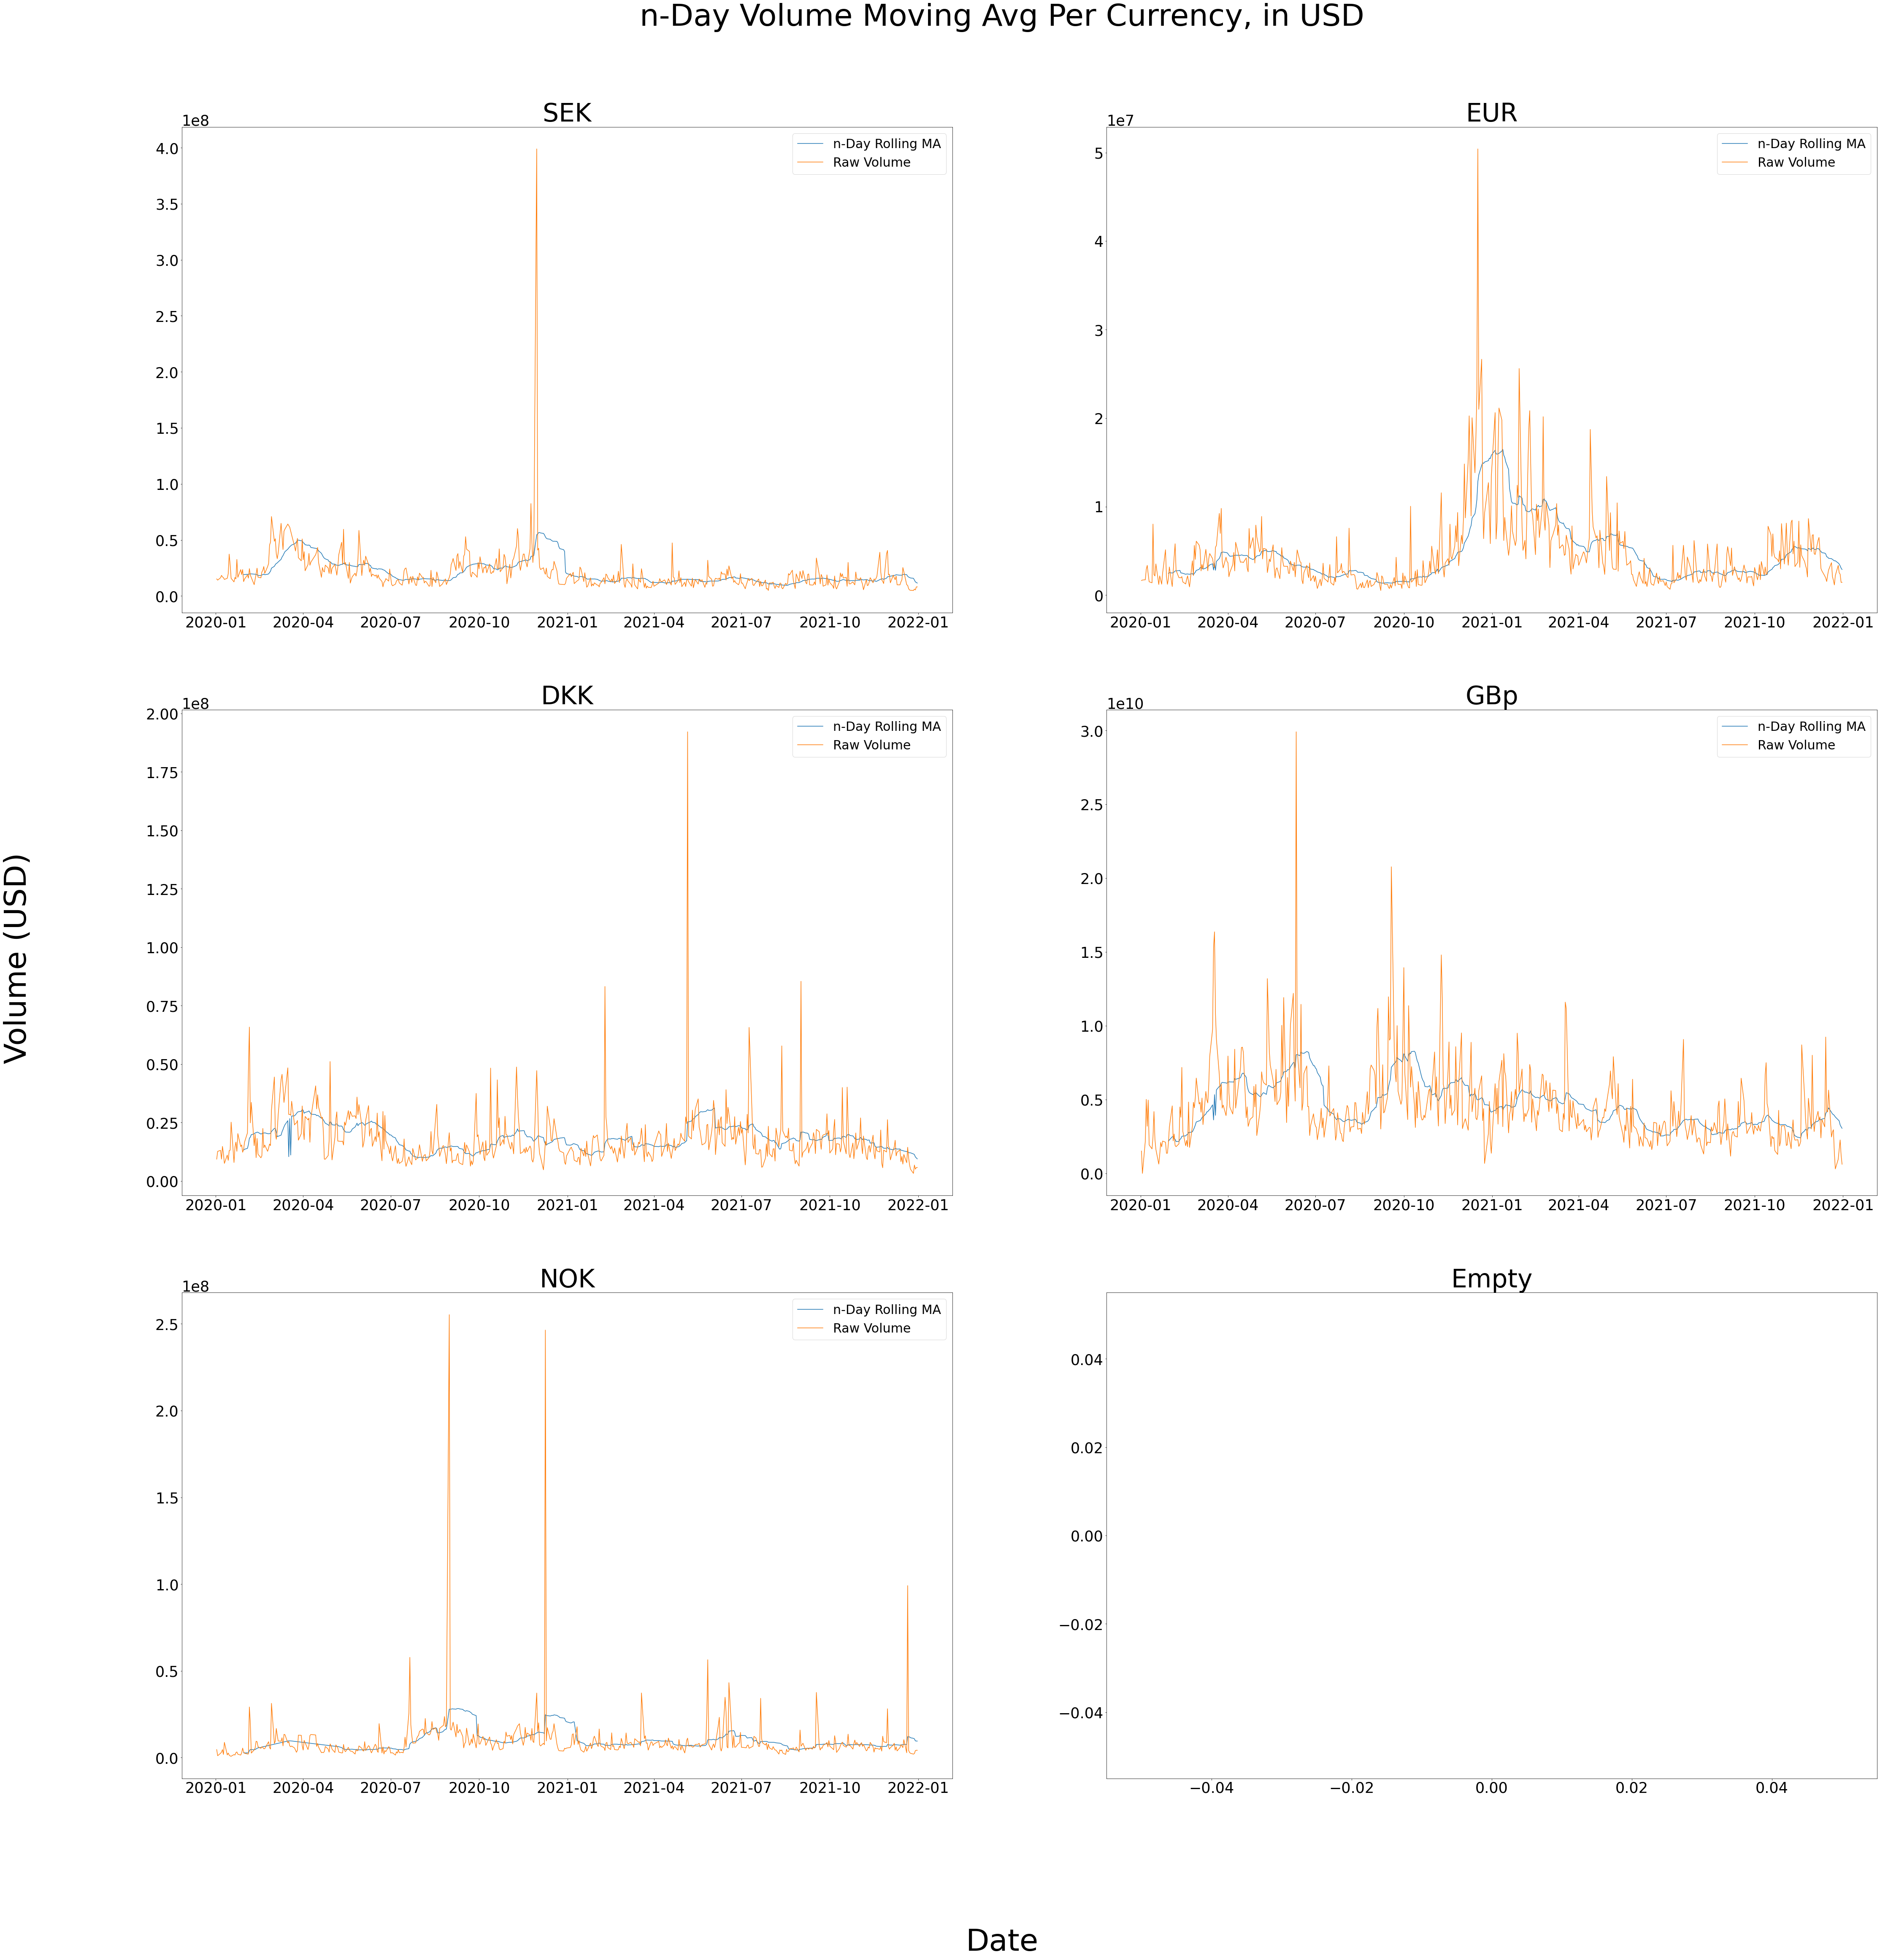

In [107]:
plot_vol_MA(21, df_set, currency_dict)
